# Hareketli Ortalama

Hareketli Ortalamalar, bir kıymetin belirli bir süre boyunca ortalama fiyatını gösteren fiyat tabanlı, gecikmeli (veya reaktif) göstergelerdir. Hareketli Ortalama, momentumu ölçmenin yanı sıra trendleri doğrulamanın ve destek ve direnç alanlarını tanımlamanın iyi bir yoludur.



Bu başlık altında önceki colab dosyalarında kullandığımız zaman serisini kullanmaya devam ediyoruz. Bu yüzden tüm kullanılan o işlevleri tekrar tanımlıyoruz. Buna ek olarak bir `tf` sınıfını kullanmamız gerekecek. O yüzden bu paketi içeri aktarark başlayalım.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Zaman")
    plt.ylabel("Değerler")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Her periyotta aynı kalıbı tekrarlar."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

## Trend, Mevsimsellik ve Beyaz Gürültü Eklenmesi


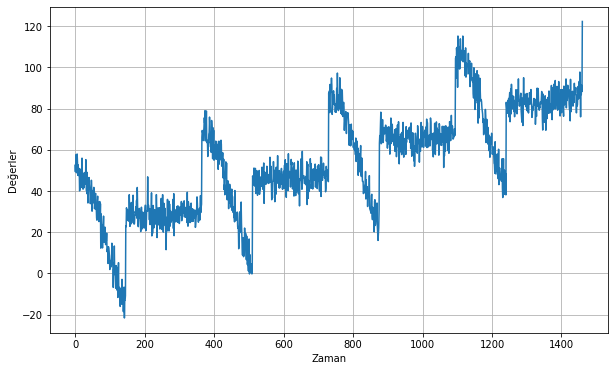

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Saf (Naif) Tahmin

Yaptığımız saf tahmini tekrar hatırlamak için tekrar tanımlayalım ve `mae` değerini bulmak için tensorflow kullanalım.

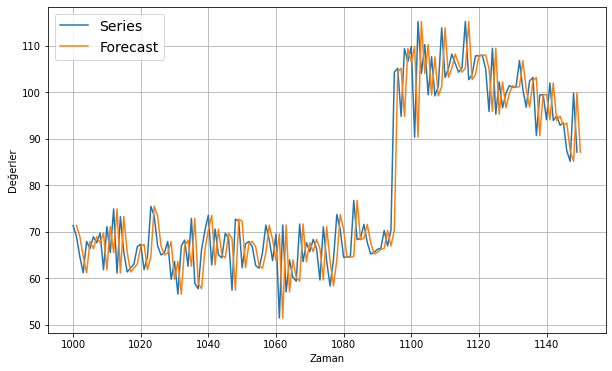

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

Şimdi, doğrulama periyodundaki tahminler ve gerçek değerler arasındaki ortalama mutlak hatayı bulalım:

In [5]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.937908515321673

## Hareketli Ortalama İçin İşlevlerin Oluşturulması

In [7]:
def moving_average_forecast(series, window_size):
  """Son birkaç değerin ortalamasını alarak tahmin yapar.
     window_size=1 olursa, bu saf tahmine eşittir"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

Aynı görevi yapacak yeni bir işlev tanımlyırouz. Bu yeni fonksiyon öncekinden çok daha hızlı çalışacaktır.

In [ ]:
def moving_average_forecast(series, window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

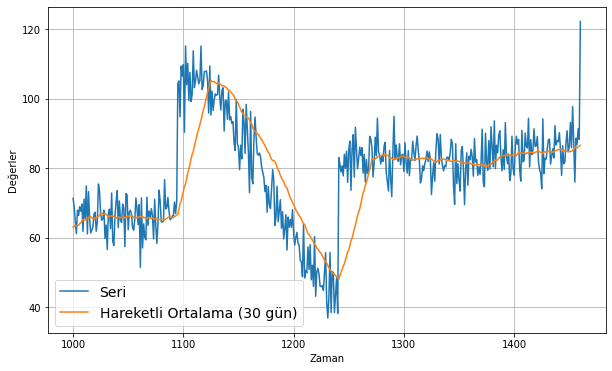

In [8]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Seri")
plot_series(time_valid, moving_avg, label="Hareketli Ortalama (30 gün)")

Görüntüden anlaşılacağı üzere saf tahminden çok daha kötü bir tahmin yeteneğine sahiptir. Hareketli ortalama, trendi veya mevsimselliği öngöremez, bu yüzden farkları kullanarak trend ve mevsimselliği ortadan kaldıralım. Mevsimsellik dönemi (periyot) 365 gün olduğundan dolayı, t zamanındaki değerden t-365 anındaki değeri çıkarmamız gerekir

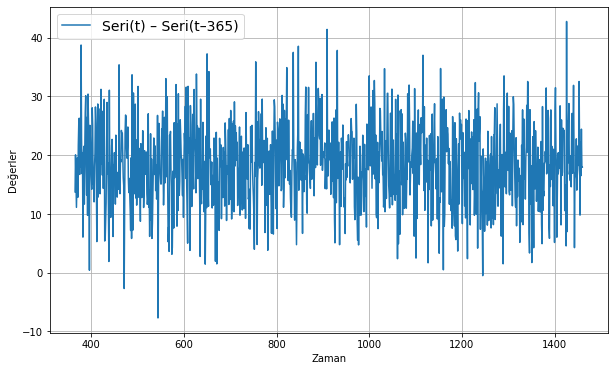

In [9]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Seri(t) – Seri(t–365)")
plt.show()

Doğrulama dönemine odaklanalım :

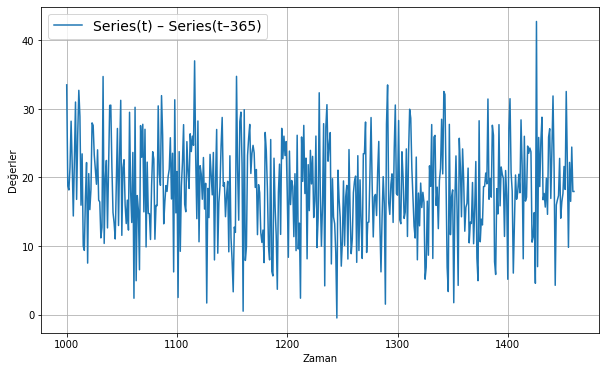

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

Oldukça iyi trend ve mevsimsellik ortadan kalkmış gibi görünüyor. Bu yüzden artık hareketli ortalamayı daha rahat kullanabiliriz.

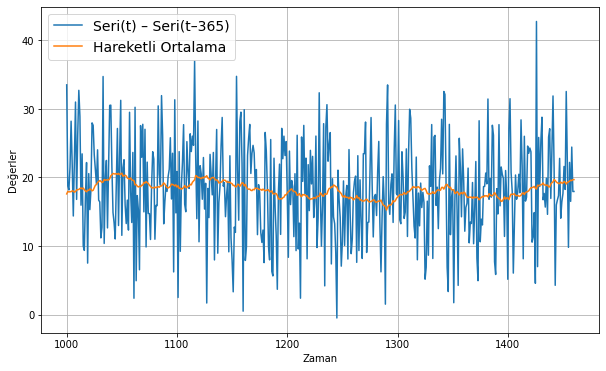

In [11]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Seri(t) – Seri(t–365)")
plot_series(time_valid, diff_moving_avg, label="Hareketli Ortalama")
plt.show()

Fena görünmüyor. Şimdi t-365 arasındaki geçmiş değerleri tekrar ekleyelim böylelikle trend ve mevsimsellik geri gelmiş olacaktır.

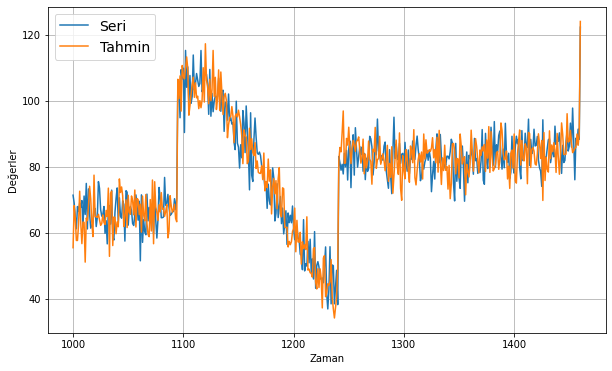

In [12]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Seri")
plot_series(time_valid, diff_moving_avg_plus_past, label="Tahmin")
plt.show()

In [13]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.839310562995895

Saf tahminden daha iyi bir sonuç aldık. Ancak tahminler biraz fazla rasgele görünüyor. Çünkü sadece gürültülü olan geçmiş değerleri ekliyoruz. Gürültünün bir kısmını ortadan kaldırmak için geçmiş değerler üzerinde hareketli bir ortalama kullanalım.

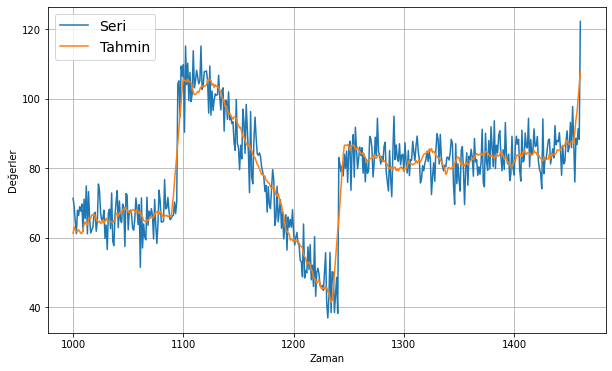

In [14]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Seri")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Tahmin")
plt.show()

In [15]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.56685995897077

Bu değer oldukça iyi. Makine öğrenmesi modelleri daha iyisini yapabilir mi deneyelim.